In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import pickle

# Function Definitions

In [2]:
def get_jackknife_blocks(data,block_size,f=lambda x:x):
    N = int(len(data)/block_size)
    data_mean = np.mean(data,axis=0)*N*block_size
    block_avgs = []
    for i in range(N):
        block_av=np.copy(data_mean)
        for j in range(block_size):
            block_av -= data[i*block_size+j]
        block_av /= (N-1)*block_size
        block_avgs.append(f(block_av))
    return block_avgs

def get_errors_from_blocks(est_value,blocks):
    N = len(blocks)
    err = 0
    bias = 0
    for i in range(N):
        err = np.add(err, (N-1)/N*np.power(np.subtract(est_value,blocks[i]),2))
        bias = np.add(bias,np.divide(blocks[i],N))
    err = np.power(err,0.5)
    return [np.add(est_value,np.multiply(N-1,np.subtract(est_value,bias))), err]

def jackknife(data,f=np.mean):
    N = len(data)
    err = 0
    bias = 0
    data_f = f(data)
    for i in range(N):
        d = data.pop(i)
        omit_f = f(data)
        err = np.add(err, (N-1)/N*np.subtract(data_f,omit_f)**2)
        bias = np.add(bias,np.divide(omit_f,N))
        data.insert(i, d)
    err = np.power(err,0.5)
    return [np.add(data_f,np.multiply(N-1,np.subtract(data_f,bias))), err]

def jackknife2(data1,data2,f):
    N = len(data1)
    err = 0
    bias = 0
    data_f = f(data1,data2)
    for i in range(N):
        d1 = data1.pop(i)
        d2 = data2.pop(i)
        omit_f = f(data1,data2)
        err = np.add(err, (N-1)/N*np.subtract(data_f,omit_f)**2)
        bias = np.add(bias,np.divide(omit_f,N))
        data1.insert(i, d1)
        data2.insert(i, d2)
    err = np.power(err,0.5)
    return [np.add(data_f,np.multiply(N-1,np.subtract(data_f,bias))), err]

def get_obs_avg(data, cutoff=0, corr_dist=1):
    avg = np.mean([data[i] for i in range(cutoff, len(data), corr_dist)])
    err = np.std([data[i] for i in range(cutoff, len(data), corr_dist)])/((len(data)-cutoff)/corr_dist)**0.5
    return [avg, err]

def get_obs_avg_jackknife(data, cutoff=0, block_size=1):
    return jackknife([data[i] for i in range(cutoff, len(data))], block_size, np.mean)

def get_correlator_avgs(corrs, cutoff=0, corr_dist=1):
    avgs = [np.mean([corrs[i][j] for i in range(cutoff,len(corrs),corr_dist)]) for j in range(len(corrs[0]))]
    errs = [np.std([corrs[i][j] for i in range(cutoff,len(corrs),corr_dist)])/((len(corrs)-cutoff)/corr_dist)**0.5 for j in range(len(corrs[0]))]
    # Because of periodic boundary conditions, the last correlator should be equal to the first
    avgs.append(avgs[0])
    errs.append(errs[0])
    return [avgs, errs]

def get_correlator_avgs_jackknife(corrs, cutoff=0, corr_dist=1):
    avgs = []
    errs = []
    for i in range(len(corrs[0])):
        a, b = jackknife([corrs[j][i] for j in range(cutoff, len(corrs), corr_dist)], np.mean)
        avgs.append(a)
        errs.append(b)
    # Because of periodic boundary conditions, the last correlator should be equal to the first
    avgs.append(avgs[0])
    errs.append(errs[0])
    return [avgs, errs]

cosh_model = lambda nt,A0,m_pi : [A0*np.cosh((Nt/2.0-nt[i])*m_pi) for i in range(len(nt))]

def find_mass_from_fit(corr_avgs, fit_range_start, mass_guess=0.3):
    Nt = len(corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    A0_guess = .1#np.abs(corr_avgs[int(Nt/2)])
    a = corr_avgs[fit_range_start:int(Nt)+1-fit_range_start]
    pi_opt, pi_cov = curve_fit(cosh_model, nt, corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 
                               p0=[A0_guess,mass_guess])
    return [np.abs(pi_opt[1]), pi_opt[0]]

def autocorr(data):
    N = len(data)
    mean = np.mean(data)
    variance = np.var(data)
    data = np.subtract(data,mean)
    r = np.correlate(data, data, mode = 'full')[-N:]
    assert np.allclose(r, np.array([np.sum(np.multiply(data[:N-k],data[-(N-k):])) for k in range(N)]))
    result = r/(variance*(np.arange(N, 0, -1)))
    return result

# Data Initialization

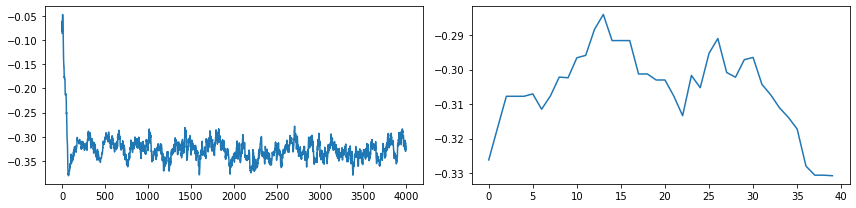

Average acceptance rate after cutoff: 0.710620314742489


In [3]:
# Extent of the lattice
Nx = 8
Nt = 16
# Spacial volume of the lattice
Vx = Nx**3
# The parameters in the action
m_sq = -10000.
lmbd = 50000.
alpha = 0.1

date = "2022-10"
day = "10"
version = "_1-4"

# The number of trajectories until thermalization
cutoff = 1000
# The size of the blocks needed to get uncorrelated block averages
block_size = 200

# Load the data
with open(f"sigma_pion_corrs_{Nx}x{Nt}_msq_{m_sq}_lmbd_{lmbd}_alph_{alpha}_{date}-{day}{version}.bin","rb") as input:
    data = pickle.load(input)
accept_rates = data["accept_rates"]
psq_list = data["psq_list"]
phi_list = data["phi_list"]
timeslices = data["timeslices"]
hm_timeslices = data["hm_timeslices"]
A_timeslices = data["ax_cur_timeslices"]
phi_sq_dist = data["phi_sq_dist"]
phi_i_dist = data["phi_i_dist"]
theta_dist = data["theta_dist"]
psq_pred_list = data["psq_pred_list"]
phi_pred_list = data["phi_pred_list"]
timeslices_pred = data["timeslices_pred"]
hm_timeslices_pred = data["hm_timeslices_pred"]
A_timeslices_pred = data["ax_cur_timeslices_pred"]
fields = data["fields"]
momentums = data["momentums"]
fields_pred = data["field_pred"]

# Plot an observable
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
axes[0].plot([phi_list[i][0] for i in range(0,len(psq_list))])
axes[1].plot([phi_list[i][0] for i in range(cutoff,cutoff+40)])

plt.tight_layout()
plt.show()

print(f"Average acceptance rate after cutoff: {np.mean(accept_rates[cutoff:])}")

# Block Size Determination
This part of the code can be used to determine the appropriate block_size, but does not need to be run every time.

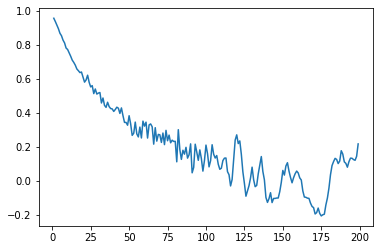

In [4]:
k_phi0=range(1,200)
ac_phi0 = []
phi0s = []
phi0_errs = []
for k in k_phi0:
    blocks = get_jackknife_blocks([phi_list[i][0] for i in range(cutoff,len(phi_list))], k)
    [phi0k,phi0k_err] = get_errors_from_blocks(np.mean([phi_list[i][0] for i in range(cutoff,len(phi_list))]), blocks)
    phi0s.append(phi0k)
    phi0_errs.append(phi0k_err)
    ac_phi0.append(autocorr(blocks)[1])
plt.plot(k_phi0,ac_phi0)

<ErrorbarContainer object of 3 artists>

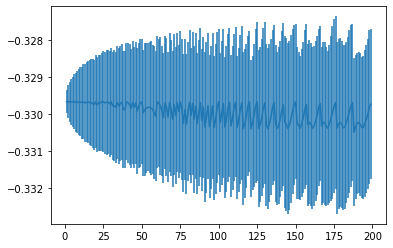

In [6]:
plt.errorbar(k_phi0, phi0s, yerr=phi0_errs)

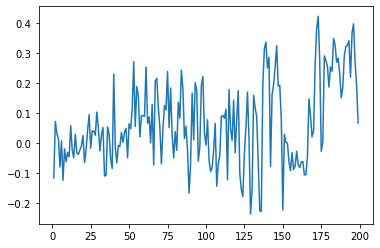

In [8]:
x=range(1,200)
ac_psq = []
for k in x:
    ac_psq.append(autocorr(get_jackknife_blocks(psq_list[cutoff:], k))[1])
plt.plot(x,ac_psq)

In [9]:
def pion_correlator(tslices,Vx,Nt,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (tslices[t0%Nt][1]*tslices[(t0+delta_t)%Nt][1] + 
                tslices[t0%Nt][2]*tslices[(t0+delta_t)%Nt][2] + 
                tslices[t0%Nt][3]*tslices[(t0+delta_t)%Nt][3])/3.0
    return rtn/Nt
end = len(timeslices)
pi_corrs = [[pion_correlator(timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,end)]
pi_corr_avgs = np.mean(pi_corrs,axis=0)

In [10]:
f = lambda data : find_mass_from_fit(data, 0, 1.0)
end = len(pi_corrs)
pi_masses=[]
pi_mass_errors=[]
vars_pi_mass=[]
ac_pi_mass=[]
k_pi_mass=range(1,200)
for k in k_pi_mass:
    blocks = get_jackknife_blocks([pi_corrs[i] for i in range(end)], k, f)
    [[mk,Ak],[ek,eAk]] = get_errors_from_blocks(f(pi_corr_avgs), blocks)
    pi_masses.append(mk)
    pi_mass_errors.append(ek)
    vars_pi_mass.append(np.var(blocks))
    ac_pi_mass.append(autocorr([blocks[i][0] for i in range(len(blocks))])[1])

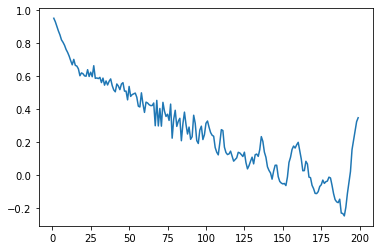

In [11]:
plt.plot(k_pi_mass,ac_pi_mass)

<ErrorbarContainer object of 3 artists>

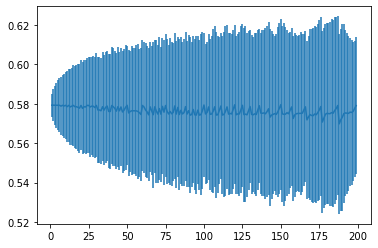

In [12]:
plt.errorbar(k_pi_mass, pi_masses, yerr=pi_mass_errors)

# Vacuum Expectation Values

In [5]:
end = len(phi_list)
vev_sigma_blocks = get_jackknife_blocks([phi_list[i][0] for i in range(cutoff,end)], block_size)
vev_sigma, vev_sigma_err = get_errors_from_blocks(np.mean(vev_sigma_blocks),vev_sigma_blocks)
print(f"Vacuum Expectation Value of sigma = {vev_sigma} +- {vev_sigma_err}")

Vacuum Expectation Value of sigma = -0.3296702545670566 +- 0.001935687052187447


# Correlators

In [6]:
def pion_correlator(tslices,Vx,Nt,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (tslices[t0%Nt][1]*tslices[(t0+delta_t)%Nt][1] + 
                tslices[t0%Nt][2]*tslices[(t0+delta_t)%Nt][2] + 
                tslices[t0%Nt][3]*tslices[(t0+delta_t)%Nt][3])/3.0
    return rtn/Nt
end = len(timeslices)
pi_corrs = [[pion_correlator(timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,end)]
pi_corr_avgs = np.mean(pi_corrs,axis=0)

In [7]:
def sigma_correlator(tslices,Vx,Nt,vev_sigma,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (tslices[t0%Nt][0]/Vx-vev_sigma)*(tslices[(t0+delta_t)%Nt][0]/Vx-vev_sigma)
    return rtn/Nt

end=len(timeslices)
s_corrs = [[sigma_correlator(timeslices[i],Vx,Nt,vev_sigma,dt) for dt in range(Nt)] for i in range(cutoff,end)]
s_corr_avgs = np.mean(s_corrs,axis=0)

# Quick Calculations

In [8]:
print(f"The pion mass is approximately: {-np.log(pi_corr_avgs[1]/pi_corr_avgs[0])}")
print(f"The sigma mass is approximately: {-np.log(s_corr_avgs[1]/s_corr_avgs[0])}")
print(f"F_pi is approximately: {2**0.5*alpha*pi_corr_avgs[0]**0.5/((-np.log(pi_corr_avgs[1]/pi_corr_avgs[0]))**(3/2)*Vx**.5)}")

The pion mass is approximately: 0.5611311936967766
The sigma mass is approximately: 0.916497519316428
F_pi is approximately: 0.4387572205436623


# Pion Mass

In [9]:
f = lambda data : find_mass_from_fit(data, 0, 1.0)
end = len(pi_corrs)

pion_mass_blocks = get_jackknife_blocks([pi_corrs[i] for i in range(end)], block_size, f)
[[pion_mass, A_pion],[pion_mass_err,A_pion_err]] = get_errors_from_blocks(f(pi_corr_avgs), pion_mass_blocks)

print(f"Pion mass is {pion_mass}/a +- {pion_mass_err}/a")

Pion mass is 0.5802840398318019/a +- 0.03446122412856115/a


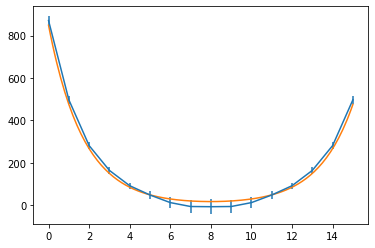

In [10]:
pi_corr_avg_blocks = get_jackknife_blocks(pi_corrs,block_size)
pi_corr_avgs_bc, pi_corr_errs = get_errors_from_blocks(pi_corr_avgs, pi_corr_avg_blocks)

plt_start = 0
plt_end = len(pi_corr_avgs) - plt_start
plt.errorbar(range(plt_start,plt_end), pi_corr_avgs_bc[plt_start:plt_end], yerr=pi_corr_errs[plt_start:plt_end])

nt_plt = np.arange(plt_start,plt_end-1+0.1,0.1)
plt.plot(nt_plt, cosh_model(nt_plt, A_pion, pion_mass))

# Sigma Mass

In [11]:
f = lambda data : find_mass_from_fit(data, 0, 1.0)
end = len(s_corrs)

sigma_mass_blocks = get_jackknife_blocks([s_corrs[i] for i in range(end)], block_size, f)
[[sigma_mass, A_sigma],[sigma_mass_err,A_sigma_err]] = get_errors_from_blocks(f(s_corr_avgs), sigma_mass_blocks)

print(f"Sigma mass is {sigma_mass}/a +- {sigma_mass_err}/a")

Sigma mass is 0.8825634334806838/a +- 0.03993455084583685/a


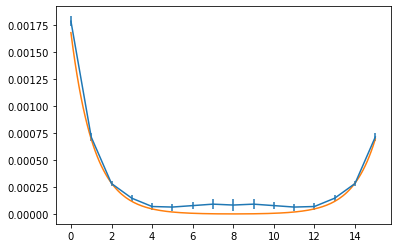

In [12]:
s_corr_avg_blocks = get_jackknife_blocks(s_corrs,block_size)
s_corr_avgs_bc, s_corr_errs = get_errors_from_blocks(s_corr_avgs, s_corr_avg_blocks)

plt_start = 0
plt_end = len(s_corr_avgs) - plt_start
plt.errorbar(range(plt_start,plt_end), s_corr_avgs_bc[plt_start:plt_end], yerr=s_corr_errs[plt_start:plt_end])

nt_plt = np.arange(plt_start,plt_end-1+0.1,0.1)
plt.plot(nt_plt, cosh_model(nt_plt, A_sigma, sigma_mass))

<ErrorbarContainer object of 3 artists>

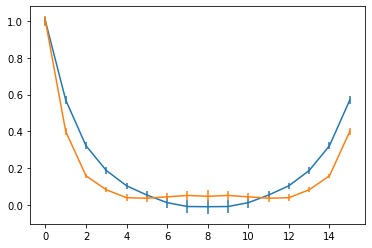

In [13]:
plt_start = 0
plt_end = len(s_corr_avgs) - plt_start
plt.errorbar(range(plt_start,plt_end), pi_corr_avgs_bc[plt_start:plt_end]/pi_corr_avgs_bc[0], yerr=pi_corr_errs[plt_start:plt_end]/pi_corr_avgs_bc[0])
plt.errorbar(range(plt_start,plt_end), s_corr_avgs_bc[plt_start:plt_end]/s_corr_avgs_bc[0], yerr=s_corr_errs[plt_start:plt_end]/s_corr_avgs_bc[0])

# Pion Decay Constant

In [44]:
def axpi_correlator(tslices,Atslices,Vx,Nt,delta_t):
    rtn = 0
    for t0 in range(Nt):
        rtn += (Atslices[(t0+delta_t)%Nt][0]*tslices[t0%Nt][1] + 
                Atslices[(t0+delta_t)%Nt][1]*tslices[t0%Nt][2] + 
                Atslices[(t0+delta_t)%Nt][2]*tslices[t0%Nt][3])/3.0
    return rtn/Nt

end = len(timeslices)
A_corrs = [[axpi_correlator(timeslices[i],A_timeslices[i],Vx,Nt,dt) for dt in range(Nt)] for i in range(cutoff,end)]

A_corr_avgs = np.mean(A_corrs,axis=0).tolist()

In [47]:
fpi_model = lambda nt,f_pi,m_pi : [-f_pi**2*m_pi*Vx*np.exp(-m_pi*Nt/2)*np.sinh((Nt/2-nt[i]+1/2)*m_pi)*(np.sinh((Nt/2-nt[i]-1/2)*m_pi)-np.sinh((Nt/2-nt[i]+0.5)*m_pi))/(alpha*np.cosh((Nt/2-nt[i])*m_pi)) for i in range(len(nt))]

def fpi_fit(A_corr_avgs, fit_range_start=1, fpi_guess=2.3, mpi_guess=0.2):
    Nt = len(pi_corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    pi_opt, pi_cov = curve_fit(lambda nt, fpi, mpi : fpi_model(nt,fpi,mpi), nt, 
                               A_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start],
                               p0=[fpi_guess, mpi_guess])
    return pi_opt

fpi_blocks = get_jackknife_blocks(A_corrs, block_size, fpi_fit)
[[fpi, mpi_from_fpi],[fpi_err,mpi_from_fpi_err]] = get_errors_from_blocks(fpi_fit(A_corr_avgs), fpi_blocks)

print(f"F_pi is {fpi}/a +- {fpi_err}/a")
print(f"m_pi is {mpi_from_fpi}/a +- {mpi_from_fpi_err}/a")

m_pi is 0.5539450635834756/a +- 0.038942978002727745/a
F_pi is 0.45792603631307377/a +- 0.02731134101012251/a


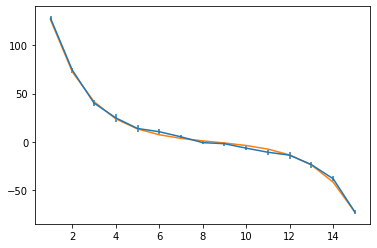

In [48]:
def f(A_corr_avgs):
    return A_corr_avgs[1:int(Nt)]

A_blocks = get_jackknife_blocks(A_corrs, block_size, f)
a,b = get_errors_from_blocks(A_corr_avgs[1:int(Nt)],A_blocks)

plt.errorbar(range(1,Nt), a, yerr=b)
plt.plot(range(1,Nt), fpi_model(range(1,Nt), fpi, mpi_from_fpi))

## Alternative Method for Determining $F_\pi$

In [49]:
fpi_model2 = lambda nt,A0,m_pi,alpha : [-A0/alpha*(m_pi*Vx*np.exp(-m_pi*Nt/2))**0.5*(np.sinh((Nt/2.0-nt[i]-1/2)*m_pi)-
                                                                                    np.sinh((Nt/2.0-nt[i]+1/2)*m_pi))/
                                       (np.cosh((Nt/2.0-nt[i])*m_pi))**0.5 for i in range(len(nt))]

def fpi_fit2(pi_corr_avgs, fit_range_start=0, A0_guess=2.0, mpi_guess=0.2):
    Nt = len(pi_corr_avgs) - 1
    nt = range(fit_range_start,int(Nt)+1-fit_range_start)
    for i in range(len(pi_corr_avgs)):
        if pi_corr_avgs[i]<0:
            pi_corr_avgs[i]=0
    a = np.power(pi_corr_avgs[fit_range_start:int(Nt)+1-fit_range_start], 0.5)
    a = np.nan_to_num(a)
    pi_opt, pi_cov = curve_fit(lambda nt,A0,pi_mass : fpi_model2(nt,A0,pi_mass,alpha), nt, 
                               a, p0=[A0_guess, mpi_guess])
    return pi_opt

fpi_blocks2 = get_jackknife_blocks(pi_corrs, block_size, fpi_fit2)
[[fpi2, mpi_from_fpi2],[fpi_err2,mpi_from_fpi_err2]] = get_errors_from_blocks(fpi_fit2(pi_corr_avgs), fpi_blocks2)

print(f"F_pi is {fpi2}/a +- {fpi_err2}/a")
print(f"m_pi is {mpi_from_fpi2}/a +- {mpi_from_fpi_err2}/a")

F_pi is 0.3174562604106633/a +- 0.08430252327659167/a
m_pi is 0.6952478372786082/a +- 0.1157638005558794/a


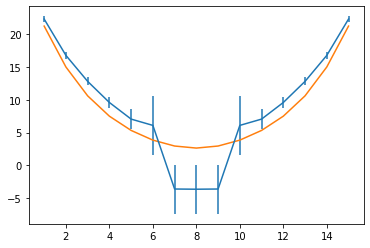

In [50]:
def f(pi_corr_avgs):
    for i in range(len(pi_corr_avgs)):
        if pi_corr_avgs[i]<0:
            pi_corr_avgs[i]=0
    return np.power(pi_corr_avgs[1:int(Nt)], 0.5)

f_blocks = get_jackknife_blocks(pi_corrs, block_size, f)
a,b = get_errors_from_blocks(f(pi_corr_avgs),f_blocks)

plt.errorbar(range(1,len(a)+1), a, yerr=b)
plt.plot(range(1,Nt), fpi_model2(range(1,Nt), fpi2, mpi_from_fpi2, alpha))